In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU, Dot
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
# from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import pickle
import os
import shutil

import random as rn

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# import ray
# from ray.tune.integration.keras import TuneReporterCallback
# from ray import tune
# from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

from scipy import stats

# import ROOT as rt

# from ROOT import TCanvas, TFile, TPaveText
# from ROOT import gROOT, gBenchmark
# from ROOT import TF1

# from ROOT import kGreen
# import numpy as np
# from ROOT import TCanvas, TGraph

from config import *
from vae_utility import *
from utils import *

Using TensorFlow backend.
/home/roberto/anaconda3/envs/vae_wh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/vae_wh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/vae_wh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/roberto/ana

In [2]:
weight_KL_loss = 0.6

In [3]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

In [4]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)


class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

In [5]:
from keras.models import load_model
custom_objects = {
#     'original_dim': original_dim,
#     'latent_dim': latent_dim,
#     'intermediate_dim': intermediate_dim,
#     'act_fun': act_fun,
#     'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,
    'IdentityLoss' : IdentityLoss
}

In [6]:
path = 'model_results/model_dependent/multiple_train/650_300/0_1_3_ft_3/w_5_10_10/vae_0.h5'

sig_inj = path.split('/')[3]
check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model {}'.format(check_vae))
elif 'autoencoder' in check_vae:
    print(' \x1b[31m pay attention, you are loading autoencoder e not vae \x1b[0m')

with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
    components_dict = pickle.load(handle)
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for uputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights
print(components_dict)
# print('latent dim', latent_dim)

you are loading a vae model vae_0.h5
{'met': 5, 'mt': 10, 'mct2': 10}


In [7]:
infer_component = False #This is automatic inference when all weights in components dicts are == 0
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    elif not infer_component:
        selected_components =['met', 'mt', 'mct2']
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        print('no automatic inference, custom component loss definition {}'.format(selected_components)) 
    
else: #if w are all != 0 we need to input our selection
    
    print('no zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        cols_sel = selected_components
        print('automatic loss component inference {}'.format(selected_components))
        
    else:    
        selected_components = ['met', 'mt', 'mct2']
        cols_sel = selected_components
        print('no zeros in the weights, custom loss component definitions {}'.format(selected_components)) 
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]

cols_sel = selected_components
Nf_lognorm=0
Nf_PDgauss=0
for selected in selected_components:
    if selected in cols[:-3]:
        Nf_lognorm += 1
    else:
        Nf_PDgauss += 1
    
print('lognorm {} and pdgauss {}'.format(Nf_lognorm, Nf_PDgauss))

no zeros in the weights
no zeros in the weights, custom loss component definitions ['met', 'mt', 'mct2']
lognorm 3 and pdgauss 0


In [8]:
vae = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: vae_0.h5 trained on non-zero loss: ['met', 'mt', 'mct2']  

 total loss weights [5, 10, 10] and individual loss weight: [5, 10, 10]  

selected output indexes [2, 3, 4] (shifetd by two beacuse of model output) for the component sum that is: ['met', 'mt', 'mct2']


In [34]:
if path.split('/')[1] != 'model_dependent':
    
    model_dependent = False
    
    back = np.load(train_val_test + 'background.npy')
    train = np.load(train_val_test + 'background_train.npy')
    val = np.load(train_val_test + 'background_val.npy')

    try:
        test = np.load(train_val_test + 'background_test.npy')
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test, tacking val')
        val = np.load(train_val_test + 'background_val.npy')
        sample = 'background_val.npy'

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    print('model independent test, val reweighting {}, {}'.format(split_test, split_val))

    
elif path.split('/')[1] == 'model_dependent':
    
    model_dependent = True
    
    name_sig = sig_inj
    
#     bkg_only = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_{}.npy'\
#                    .format(name_sig, name_sig))

    back = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_{}.npy'\
                   .format(name_sig, name_sig))
    train = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_train_{}.npy'\
                    .format(name_sig, name_sig))
    val = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    val_bkg_only = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_val_{}.npy'\
                  .format(name_sig, name_sig))
    try:
        test = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        
        test_bkg = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_test_{}.npy'\
                  .format(name_sig, name_sig))
        
        test_sig = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test')

    rew_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    rew_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    rew_val_bkg_only = 1/(np.sum(val_bkg_only[:,-1])/(np.sum(back[:,-1])))
    rew_test = 1/(np.sum(test_bkg[:,-1])/(np.sum(back[:,-1])))# To fix- remove signal
    #from bkg
    
    print('model dependent on {}'.format(sig_inj))

model dependent on 650_300


In [35]:
all_signal = []
signal_name = []
all_signal_dict = {}

signal_name_path = os.listdir(numpy_sig)

for i, name in enumerate(signal_name_path):
    
    all_signal.append(np.load(numpy_sig + name))
    if 'p0' in name:
        signal_name.append(''.join(name.split('Wh_hbb_')[1].split('p0')[0:2]))
    else:
        signal_name.append(''.join(name.split('Wh_hbb_')[1].split('p5')[0:2]))
        
    all_signal_dict[signal_name[-1]] = np.load(numpy_sig + name)

In [36]:
start_c = 0
end_c = 3

reg = 'signal'
regs = ['all', 'signal', 'reg_1', 'reg_2', 'reg_3', 'exstensive']
ranges_mbb = [[100,350], [100, 140], [0,75], [75,150], [150,300], [100,600]]

range_mbb = ranges_mbb[regs.index(reg)]

# if sample_name == 'val':
    
range_mct2 = [100,1000]

val_factor = rew_val
val_df = pd.DataFrame(val, columns=cols)
sample_v = val_df[cols_sel[start_c:end_c] + ['weight']].values

out_bkg_v = vae.predict(sample_v[:,:-1], batch_size=2000)
loss_bkg_v = np.column_stack((weight_KL_loss*out_bkg_v[0]+out_bkg_v[1], 
                                  out_bkg_v[1], out_bkg_v[0])).T

test_df = pd.DataFrame(test, columns=cols)
sample_t = test_df[cols_sel[start_c:end_c] + ['weight']].values

out_bkg_t = vae.predict(sample_t[:,:-1], batch_size=2000)
loss_bkg_t = np.column_stack((weight_KL_loss*out_bkg_t[0]+out_bkg_t[1], 
                                  out_bkg_t[1], out_bkg_t[0])).T

test_bkg_df = pd.DataFrame(test_bkg, columns=cols)
sample_t_bkg_only = test_bkg_df[cols_sel[start_c:end_c] + ['weight']].values

out_bkg_only_t = vae.predict(sample_t_bkg_only[:,:-1], batch_size=2000)
loss_bkg_only_t = np.column_stack((weight_KL_loss*out_bkg_only_t[0]+out_bkg_only_t[1], 
                                  out_bkg_only_t[1], out_bkg_only_t[0])).T

test_sig_df = pd.DataFrame(test_sig, columns=cols)
sample_t_sig_only = test_sig_df[cols_sel[start_c:end_c] + ['weight']].values

out_sig_only_t = vae.predict(sample_t_sig_only[:,:-1], batch_size=2000)
loss_sig_only_t = np.column_stack((weight_KL_loss*out_sig_only_t[0]+out_sig_only_t[1], 
                                  out_sig_only_t[1], out_sig_only_t[0])).T
        
sig_factor = 1
print('sig factor: {}'.format(sig_factor))  

sig factor: 1


In [38]:
bkg_losses_dic = {'bkg_sig_val':out_bkg_v, 
                   'bkg_sig_test':out_bkg_t, 
                   'bkg_test':out_bkg_only_t
                  }

In [39]:
bkg_losses={}
for k, v in bkg_losses_dic.items():
    for i, sel in enumerate(selected_idx):
        print(sel)
        if i == 0:
            all_components_bkg = v[sel]
            all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
        else:
            all_components_bkg = np.concatenate((all_components_bkg, np.reshape(v[sel]
                                            , (len(v[sel]),1))), axis = 1)

        bkg_losses[k]=np.sum(all_components_bkg, axis=1)

2
3
4
2
3
4
2
3
4


In [40]:
# signal_name_sel = ['300_150','300_75','500_0','600_150','750_100','700_350',
#               '1000_50', '187_12', '400_200', '800_50']

sig_list = []
out_sig_list = []
losses_sig = []
for name in signal_name:
    sig = all_signal_dict[name]

    sig_df = pd.DataFrame(sig, columns=cols)
    sig = sig_df[cols_sel[start_c:end_c] + ['weight']].values
    sig_list.append(sig)
    
    out_sig_list.append(vae.predict(sig[:,:-1], batch_size=2000))
    losses_sig.append(np.column_stack((weight_KL_loss*out_sig_list[-1][0]+out_sig_list[-1][1],
                            out_sig_list[-1][1], out_sig_list[-1][0])).T)

all_components_sig_list = []
for out_sig in out_sig_list:
    for i, sel in enumerate(selected_idx):
#         print(i,sel)
        if i == 0:
            all_components_sig_temp = out_sig[sel]
            all_components_sig_temp = np.reshape(all_components_sig_temp
                                                 , (len(all_components_sig_temp),1))
        else:
            all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                        , np.reshape(out_sig[sel]
                                            , (len(out_sig[sel]),1))), axis = 1))
            
    all_components_sig_list.append(all_components_sig_temp)
    
bump_sig_loss_list = []

for ix, loss in enumerate(all_components_sig_list):
    
    bump_sig_loss_list.append(np.sum(loss, axis = 1))    

In [41]:
sample = 'val'

if sample == 'val':
    bump_bkg_loss = bkg_losses['bkg_sig_val']
    dataset = sample_v
    split_fact = rew_val
elif sample == 'test':
    bump_bkg_loss = bkg_losses['bkg_sig_test']
    dataset = sample_t
    split_fact = rew_test

In [42]:
display_comparison = False
sig_to_plot = True

centered_sig = sig_inj
# centered_sig = '1000_50'

if (model_dependent) & (display_comparison):
    start = signal_name.index(centered_sig)-5
    end = start+10
elif sig_to_plot:
    start = 0
    end = None
    signal_to_plot = ['300_150','300_75','500_0','600_150', '750_100', '700_350', '1000_50']
else:
    start = 0
    end = 20

model_results/model_dependent/multiple_train/650_300/0_1_3_ft_3/w_5_10_10/vae_0.h5


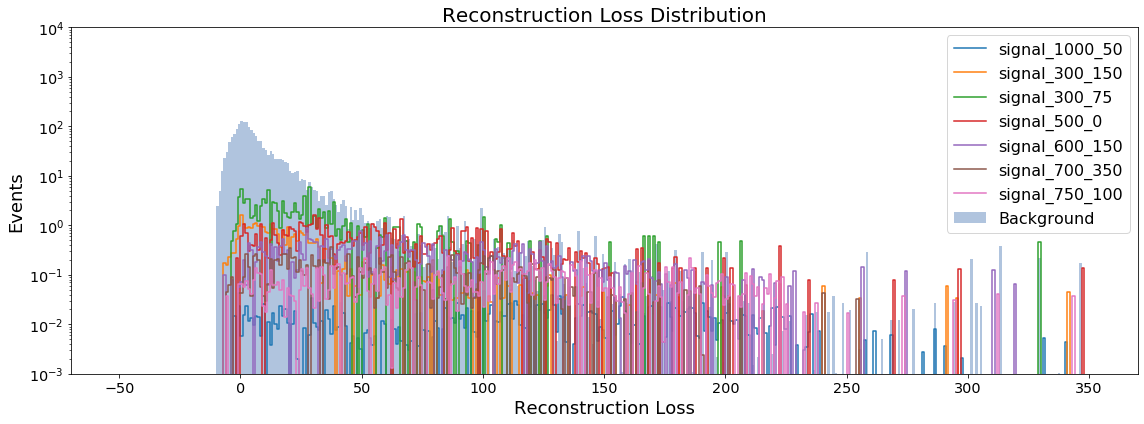

In [43]:
# signal_name_to_plot = ['300_150','500_0','600_150','700_350']
bin_factor=1
histo_start = -50
histo_end=350
f,a = plt.subplots(1,1, figsize=(16, 6))
    
# color=['purple', 'navy', 'red', 'green', 'black', 'blue']
# num_loss = 1
n = 50
density = False

for i,bump_sig_loss in enumerate(bump_sig_loss_list[start:end]):
    i = i + start
    if sig_to_plot:
        if signal_name[i] not in signal_to_plot:
            continue
    histo_range = (histo_start, histo_end)
    bins = int((histo_range[1]-histo_range[0])*bin_factor)
    counts_s, edges_s = np.histogram((bump_sig_loss).astype(float),range=histo_range, bins =bins,
                                    weights=sig_list[i][:,-1]*sig_factor,
                                     density=density
                                    )
    a.step(x=edges_s, y=np.append(counts_s, 0),
            where="post", label='signal_{}'.format(signal_name[i]))

histo_range = (histo_start, histo_end)
bins = int((histo_range[1]-histo_range[0])*bin_factor)

counts_dval, edges_dval = np.histogram((np.array(bump_bkg_loss)).astype(float)
                                       ,range=histo_range,
                                       bins =bins*100,
                                            weights=split_fact*dataset[:,-1],
                                           density=density) 
                                      
th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1]+
            edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)])/2

a.hist((np.array(bump_bkg_loss)).astype(float),range=histo_range, bins =bins,
            weights=split_fact*dataset[:,-1], 
       stacked=True, 
            density=density,
            color = ['lightsteelblue'], label=['Background'])

# if model_dependent:

#     counts_dval, edges_dval = np.histogram((np.array(bump_bkg_only_loss)).astype(float)
#                                            ,range=histo_range,
#                                            bins =bins,
#                                     weights=split_val_bkg_only*val_bkg_only[:,-1],
#                                                density=density) 
    
#     a.step(x=edges_dval, y=np.append(counts_dval, 0),
#             where="post", label='val only backround', color = 'black')
    
a.set_ylabel('Events', fontsize=18)
a.set_xlabel('Reconstruction Loss', fontsize=18)
a.set_title('Reconstruction Loss Distribution'.format(n), fontsize = 20)

a.set_ylim(10**-3,10**4)
a.tick_params(labelsize='x-large')
# a.set_xlim(-5,45)
a.legend(fontsize = 16)
a.set_yscale('log') 
# a.axvline(int(th), color='black')
# lst = [0,5,10,15,th,20,25,30, 35, 40, 45, 50, 60, 70, 80 ,90 ,100, 200, 500, 1000]
# lst = [int(x) for x in lst]
# a.set_xticks(lst)
print(path)
# plt.savefig('reconstruction_loss_phday.pdf')

plt.tight_layout()

In [44]:
# N EXP on VAL and SIG same curve 
# N = [1,2,5,8,10, 15,20, 25, 30, 40, 50, 60, 70,80, 90, 100, 120, 130, 150, 200, 250, 300, 350, 400]
N = [5, 10,20, 25, 30, 40, 50, 100, 150, 200, 250, 300, 400]

events_number = [str(x) for x in N]

value = [1]

sample_val = 'val'

if sample_val == 'val':
    reweight = rew_val
    dataset = sample_v
# elif sample_val == 'train':
#     reweight = split_train
#     dataset = sample
elif sample_val == 'test':
    reweight = rew_test
    dataset = sample_t
    
sig_factor = 1

p_value  = {}
p_v_dict ={}
p_value_all = {}
hm=None

N_exp = 1
temp_matrix = np.zeros((N_exp, len(value),len(signal_name)),dtype=object)
min_t = -100
maxi_t = 500

for index, n in enumerate(N):

    for j in range(N_exp):

        out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
        
        for i, sel in enumerate(selected_idx):
            print(sel)
            
            if i == 0:
                all_components_bkg = out_bkg[sel]
                all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
            else:
                all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                                , (len(out_bkg[sel]),1))), axis = 1)
                
        bump_loss_bkg=np.sum(all_components_bkg, axis=1)
        ####HISTO RANGE FOR VAL_LOSS DISTRIBUTION####
        histo_range = (min_t,maxi_t)
        bins_back = int(maxi_t*2000)
        counts_dval, edges_dval = np.histogram((np.array(bump_loss_bkg)).astype(float),
                                               range=histo_range, bins =bins_back,
                                               weights=dataset[:,-1]*reweight) 
            
        bump_loss_sig = []
        for sig_id, sig in enumerate(sig_list[:hm]): 

            out_sig = vae.predict(sig[:,:-1], batch_size=2000)

            for i, sel in enumerate(selected_idx):    
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))

            bump_loss_sig.append(np.sum(all_components_sig_temp, axis = 1))       
                      

        th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)]+
                    edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1])/2

        histo_range_test = (th, maxi_t)

        for i in range(len(all_signal[:hm])):

            for indices, v in enumerate(value):
                
                counts_s, edges_s = np.histogram((bump_loss_sig[i]).astype(float),
                                                    range=histo_range_test, 
                                                   bins =1, weights = sig_list[i][:,-1]*sig_factor)

                counts_d, edges_d = np.histogram((np.array(bump_loss_bkg)).astype(float)
                                                 ,range=histo_range_test, 
                                   bins =1, weights = dataset[:,-1]*reweight)

            
                temp_matrix[j,indices,i]= [counts_s[0], counts_d[0]]    
                
                print(counts_d, counts_s,signal_name[i],
                      1-(scipy.stats.poisson.cdf(counts_d + counts_s-1,counts_d)))

    for k in range(len(all_signal[:hm])):

        s_mean = []
        b_mean = []
        s_error = []
        p_value_all = {}
        for l in range(len(value)):
            s_mean.append(np.mean([x[0] for x in temp_matrix[:,l,k]]))
            b_mean.append(np.mean([x[1] for x in temp_matrix[:,l,k]]))
            s_error.append(np.std([x[0] for x in temp_matrix[:,l,k]])/np.sqrt(N_exp))

        pv = 1-(scipy.stats.poisson.cdf(b_mean[0] + s_mean[0]-1,b_mean[0]))
        p_value_all[events_number[index]] = b_mean, s_mean, s_error, [pv]

        if index == 0:
            p_v_dict[signal_name[k]] = p_value_all
        else:
            p_v_dict[signal_name[k]][events_number[index]] = p_value_all[events_number[index]]

2
3
4
[4.90249302] [1.1930691] 1000_0 [0.36693553]
[4.90249302] [1.34822957] 1000_100 [0.36693553]
[4.90249302] [1.19499743] 1000_150 [0.36693553]
[4.90249302] [1.1352756] 1000_200 [0.36693553]
[4.90249302] [1.07019951] 1000_250 [0.54223395]
[4.90249302] [0.98407773] 1000_300 [0.54223395]
[4.90249302] [1.06153437] 1000_350 [0.54223395]
[4.90249302] [0.92194475] 1000_400 [0.54223395]
[4.90249302] [1.10161955] 1000_50 [0.36693553]
[4.90249302] [4.45222284] 150_0 [0.0619143]
[4.90249302] [2.25736546] 152_22 [0.22370231]
[4.90249302] [3.09766751] 162_12 [0.12338805]
[4.90249302] [3.33006802] 165_35 [0.12338805]
[4.90249302] [3.54203404] 175_0 [0.12338805]
[4.90249302] [1.81733829] 175_25 [0.36693553]
[4.90249302] [4.53394789] 187_12 [0.0619143]
[4.90249302] [2.99491703] 187_37 [0.22370231]
[4.90249302] [0.99375055] 190_60 [0.54223395]
[4.90249302] [5.79613039] 200_0 [0.02842823]
[4.90249302] [4.39624607] 200_25 [0.0619143]
[4.90249302] [4.07867918] 200_50 [0.12338805]
[4.90249302] [0.19546

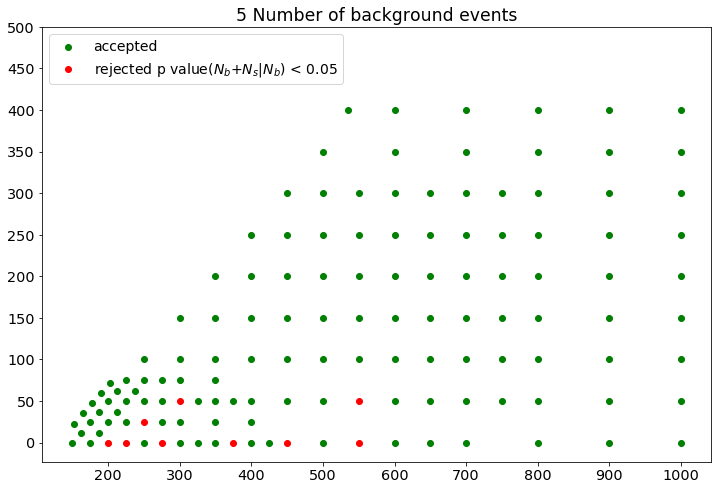

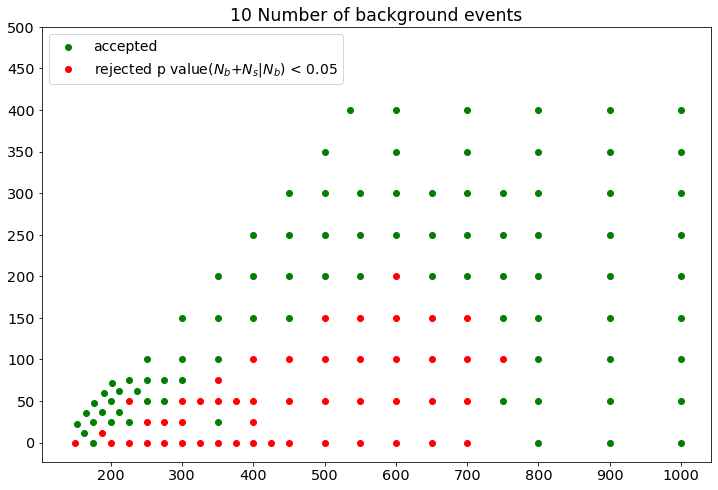

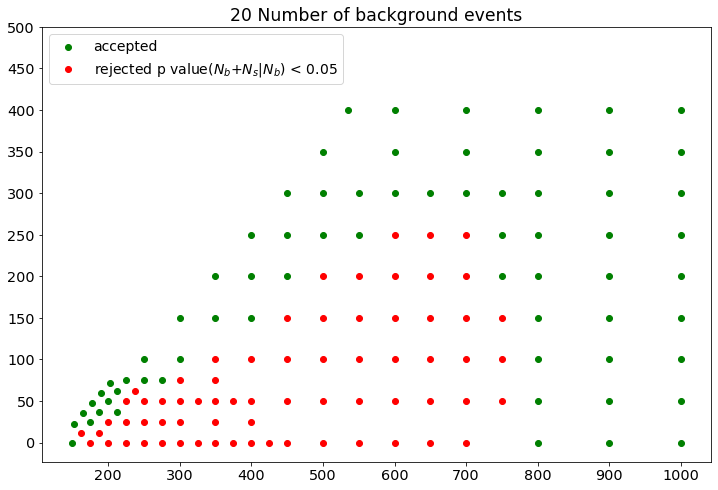

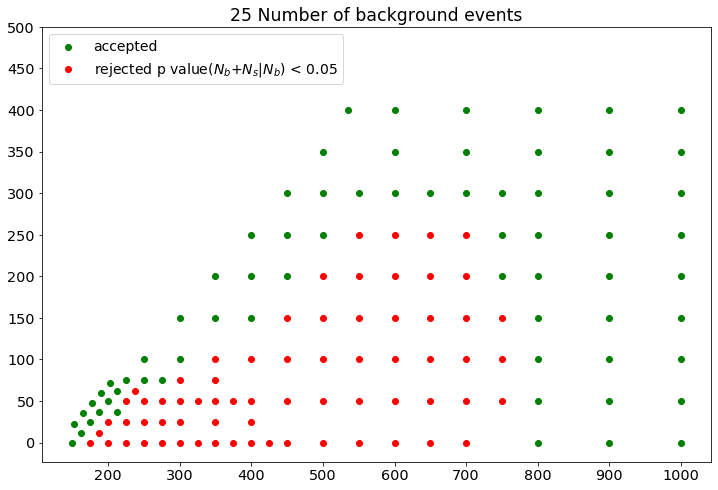

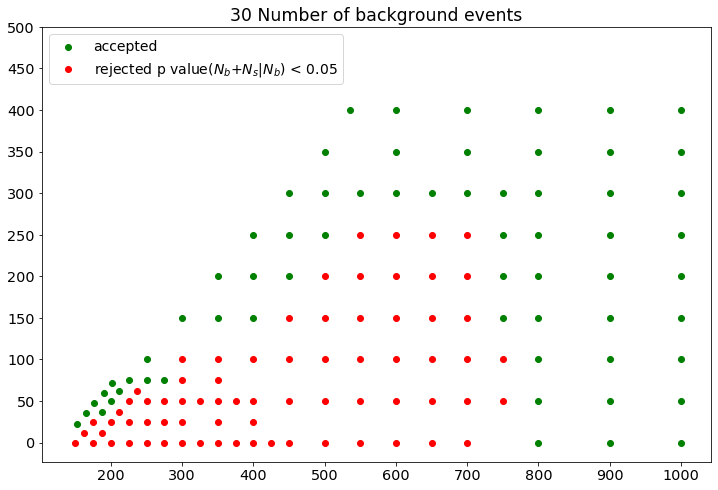

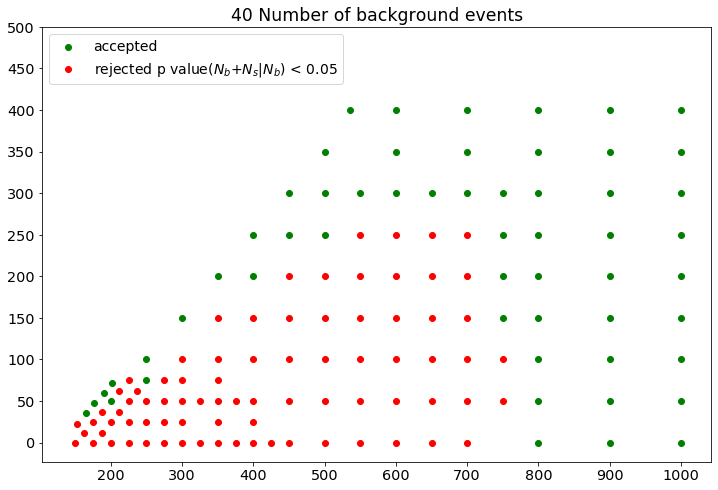

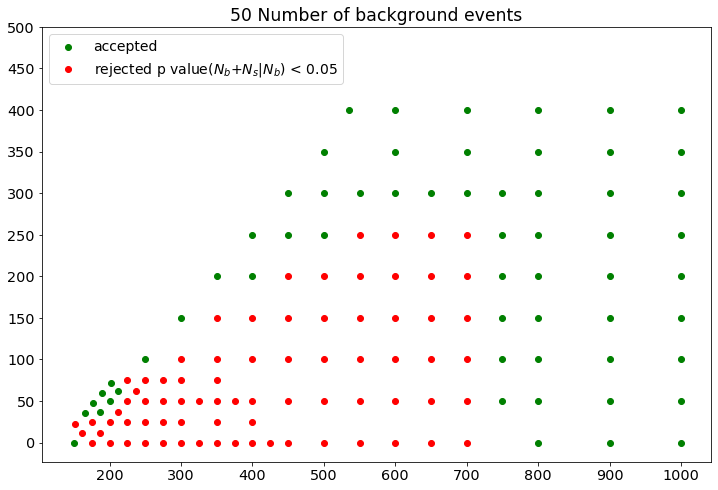

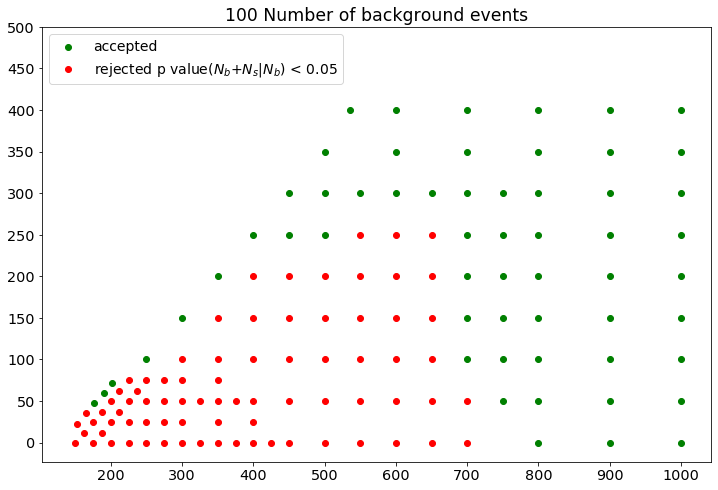

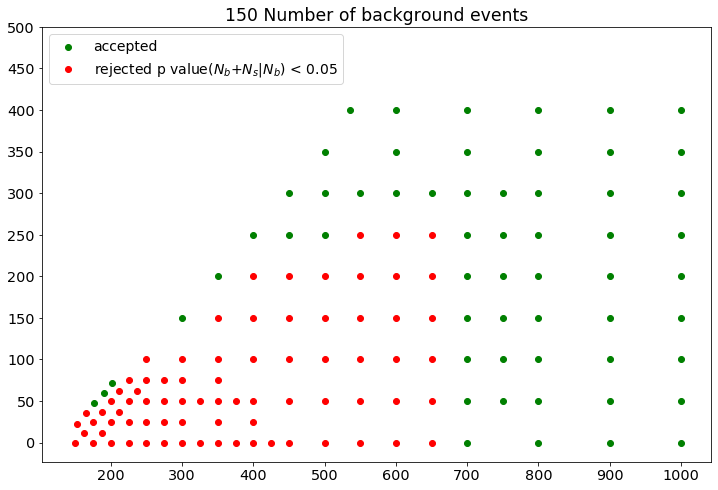

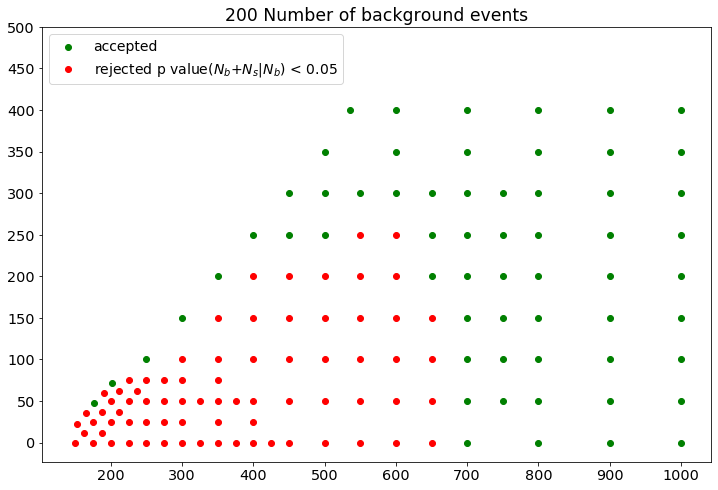

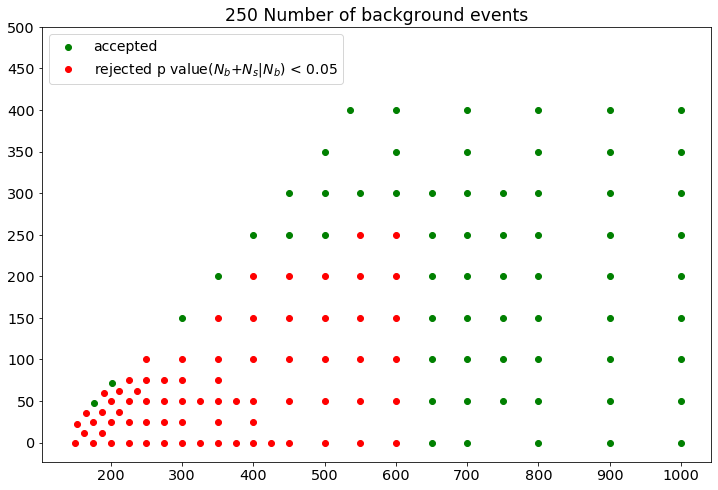

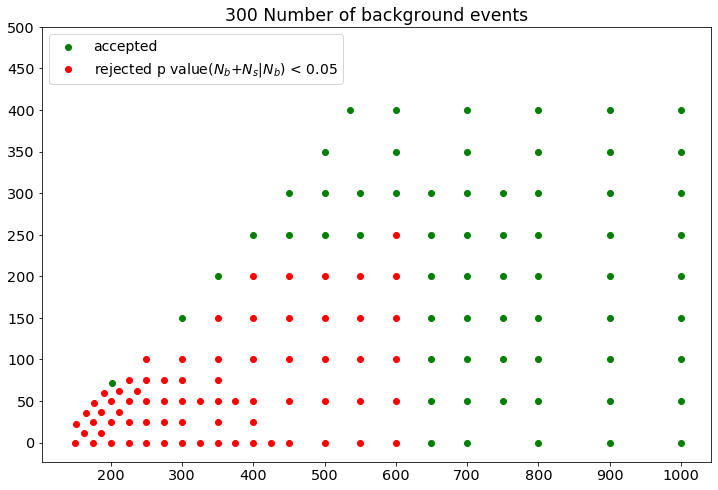

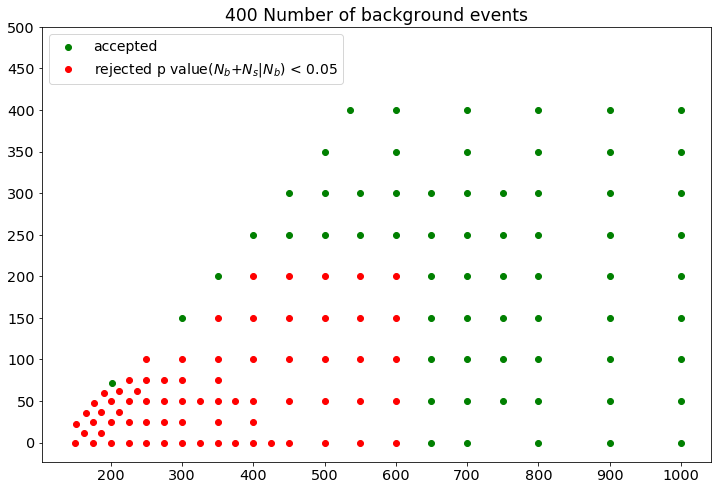

In [45]:
# f, ax_arr = plt.subplots(len(events_number),1 , figsize=(12,8*len(N)))
accepted_name = []
rejected_name = []
pv_comp = {}
for i, n in enumerate(events_number):     
        f, ax_arr = plt.subplots(1,1 , figsize=(12,8))
        x_acc=[]
        y_acc=[]
        x_rej=[]
        y_rej=[]
        for j, sig_name in enumerate(signal_name):
            if i == 0:
                pv_comp[sig_name] = {}
            pv = p_v_dict[sig_name][str(n)][-1][0]
            
            if (pv > 0.05):

                x_acc.append(int(sig_name.split('_')[0]))
                y_acc.append(int(sig_name.split('_')[1]))                        
                                
            else:

                x_rej.append(int(sig_name.split('_')[0]))
                y_rej.append(int(sig_name.split('_')[1]))
                
            if int(sig_name.split('_')[0])>=700:
                pv_comp[sig_name][n]=pv
                
                    

        ax_arr.scatter(x_acc, y_acc, color = 'green',
                                          label = 'accepted')      
        ax_arr.scatter(x_rej, y_rej, color = 'red', label = 'rejected p value($N_{b}$+$N_{s}$|$N_{b}$) < 0.05')    
        ax_arr.set_title('{} Number of background events'.format(n)
                            , size='xx-large')
        ax_arr.set_xticks([200, 300, 400, 500, 600, 700, 800, 900, 1000])
        ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
        ax_arr.legend(fontsize = 14, loc='upper left')
        ax_arr.tick_params(labelsize='x-large')  


NameError: name 'bump_bkg_loss_v' is not defined

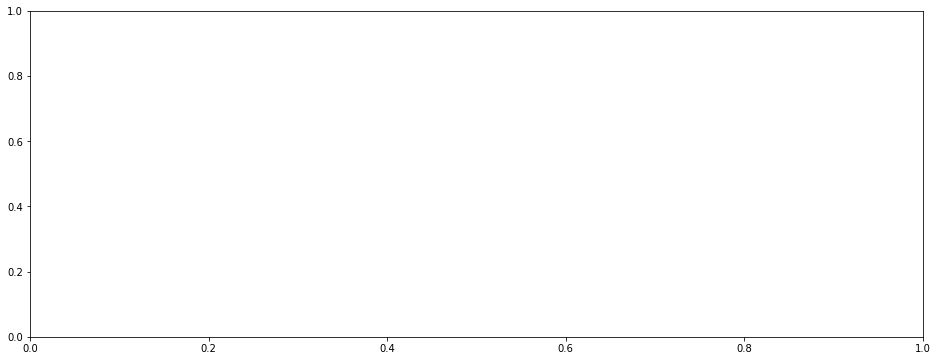

In [22]:
# signal_name_to_plot = ['300_150','500_0','600_150','700_350']
bin_factor=1
histo_start = -10
histo_end=300
f,a = plt.subplots(1,1, figsize=(16, 6))
    
# color=['purple', 'navy', 'red', 'green', 'black', 'blue']
num_loss = 1
n = 50
density = False

# 

histo_range = (histo_start, histo_end)
bins = int((histo_range[1]-histo_range[0])*bin_factor)

counts_dval, edges_dval = np.histogram((np.array(bump_bkg_loss_v)).astype(float)
                                       ,range=histo_range,
                                       bins =bins,
                                            weights=split_val*sample_v[:,-1],
                                           density=density) 

a.step(x=edges_dval, y=np.append(counts_dval, 0),
            where="post", label='val only backround', color = 'black')
    
                                      
th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1]+
            edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)])/2

# a.hist((np.array(bump_bkg_loss_v)).astype(float),range=histo_range, bins =bins,
#             weights=[split_val]*sample_v[:,-1], 
#        stacked=True, 
#             density=density,
#             color = ['lightsteelblue'], label=['Background'])

    
a.set_ylabel('Events', fontsize=18)
a.set_xlabel('Reconstruction Loss', fontsize=18)
a.set_title('Reconstruction Loss Distribution'.format(n), fontsize = 20)

a.set_ylim(10**-3,10**4)
a.tick_params(labelsize='x-large')
# a.set_xlim(-5,45)
a.legend(fontsize = 16)
a.set_yscale('log') 
a.axvline(int(th), color='black')
# lst = [0,5,10,15,th,20,25,30, 35, 40, 45, 50, 60, 70, 80 ,90 ,100, 200, 500, 1000]
# lst = [int(x) for x in lst]
# a.set_xticks(lst)
print(path)
# plt.savefig('reconstruction_loss_phday.pdf')

plt.tight_layout()

In [47]:
# from numpy import exp, linspace, random

# def gaussian(x, amp, cen, wid):
#     return amp * exp(-(x-cen)**2 / wid)

# def lognorm(x, shape, loc, scale):
#     return 1 / (shape*((x-loc)/scale)*np.sqrt(2*np.pi)) \
#                 * exp(-1/2*(np.log((x-loc)/scale)/shape)**2) / scale

# from lmfit import Model

# gmodel = Model(gaussian)
# lmodel = Model(lognorm)
# print('parameter names: {}'.format(lmodel.param_names))
# print('independent variables: {}'.format(lmodel.independent_vars))

# max(counts_dval)

# x = edges_dval[:-1]
# y = counts_dval

# params = lmodel.make_params(cen=20, amp=200, wid=1)
# # params = lmodel.make_params(shape = 2, loc = 0, scale = 1000)

# params

# # result = gmodel.fit(y, params, x=x)
# result = lmodel.fit(y, list(par[0]), x=x)

# result.params

# max(y)

# # plt.plot(x, y, 'bo')
# f,a = plt.subplots(1,1, figsize=(16, 6))
# # plt.plot(x, result.init_fit, 'k--', label='initial fit')
# a.plot(x, y, 'bo')
# a.plot(x, result.best_fit, 'r-', label='best fit')
# a.legend(loc='best')
# a.set_ylim(10**-3,10**4)
# a.tick_params(labelsize='x-large')
# # a.set_xlim(-5,45)
# a.legend(fontsize = 16)
# a.set_yscale('log') 
# plt.show()

# # ! pip install paramnormal

# import paramnormal

# # x_hat = np.logspace(-0.5, 1.75, num=100)
# # y_hat = dist.pdf(x_hat)

# # bins = np.logspace(-0.5, 1.75, num=25)
# fig, ax = plt.subplots()
# _ = ax.hist(x, bins=bins, normed=True, alpha=0.375)
# ax.plot(x_hat, y_hat, zorder=2, color='g')
# ax.set_xscale('log')
# ax.set_xlabel('$X$')
# ax.set_ylabel('Probability')
# seaborn.despine()

In [20]:
bkg_losses

{'bkg_sig_val': array([31.992    ,  3.8478193, 12.212114 , ..., 76.38694  , 34.380848 ,
        15.643153 ], dtype=float32),
 'bkg_sig_test': array([2.7572265 , 7.858778  , 0.25207722, ..., 8.014763  , 4.9294844 ,
        6.3598013 ], dtype=float32),
 'bkg_test': array([2.3229659, 2.4178734, 2.3053312, ..., 8.622731 , 1.1195159,
        4.5617833], dtype=float32)}

In [23]:
counts_only_bkg, edges_only_bkg = np.histogram((np.array(bkg_losses['bkg_test'])).astype(float)
                                       ,range=histo_range,
                                       bins =bins,
                                            weights=sample_t_bkg_only[:,-1],
                                           density=density) 

counts_only_bkg_rew, edges_only_bkg = np.histogram((np.array(bkg_losses['bkg_test'])).astype(float)
                                       ,range=histo_range,
                                       bins =bins,
                                            weights=sample_t_bkg_only[:,-1]*rew_test_bkg_on_bkg,
                                           density=density) 

In [24]:
i = 50
bump_sig_loss = bump_sig_loss_list[i]

In [25]:
counts_bs, edges_s = np.histogram((np.concatenate((np.array(bkg_losses['bkg_test'])
                                                  ,bump_sig_loss))).astype(float)
                    ,range=histo_range, bins =bins,
                 weights=np.concatenate((sample_t_bkg_only[:,-1]*rew_test_bkg_on_bkg,sig_list[i][:,-1])),
                                     density=density
                                    )

In [28]:
x = edges_only_bkg[:-1]
y_bkg = counts_only_bkg
y_bkg_rew = counts_only_bkg_rew
y_bkg_sig_rew = counts_bs

In [42]:
del bs, b

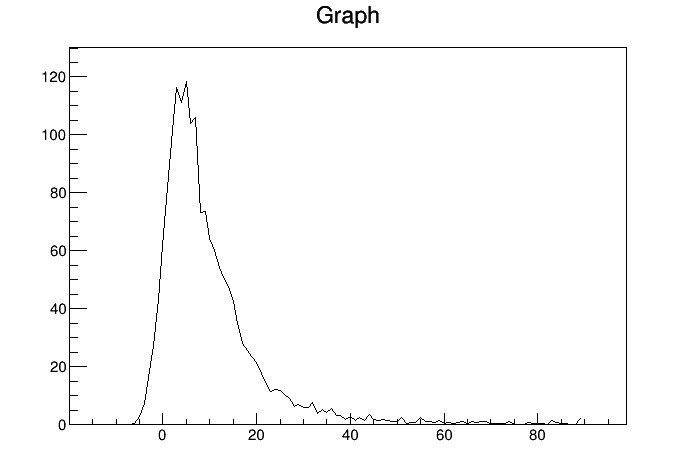

In [30]:
sqroot = gROOT.FindObject( 'sqroot' )
TFile()

# Some data
xx = x[:100]
yy = y_bkg_rew[:100]
# yyy = y_bkg_rew[:100]


#Canvas to plot on and graph
c = TCanvas()
# bs = TGraph(xx.size, xx.astype(np.double),yy.astype(np.double))
g = TGraph(xx.size, xx.astype(np.double),yy.astype(np.double))

#Draw canvas and graph
c.Draw()
g.Draw()
# bs.Draw('same')
# c.Update()


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      1055.32
NDf                       =           97
Edm                       =  1.56454e-09
NCalls                    =          113
Constant                  =      632.325   +/-   8.09693     
MPV                       =      4.28492   +/-   0.071852    
Sigma                     =      2.91654   +/-   0.049462     	 (limited)


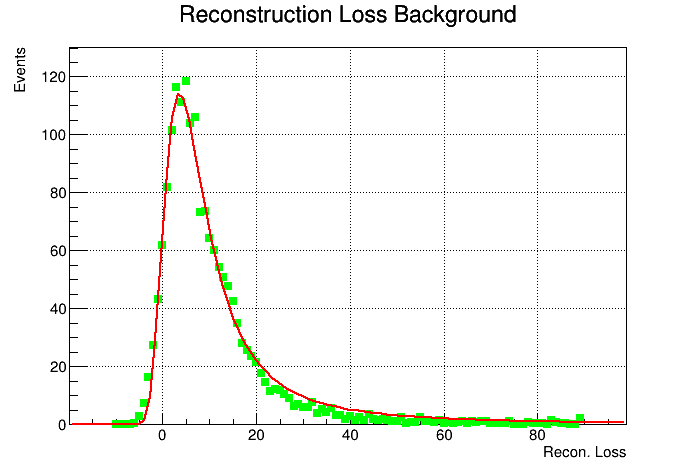

In [37]:
#Formatting
g.SetLineColor( kGreen)
g.SetLineWidth( 2 )
g.SetMarkerColor( kGreen )
g.SetMarkerStyle( 21 )

#Labels and title
g.SetTitle('Reconstruction Loss Background')
g.GetXaxis().SetTitle('Recon. Loss')
g.GetYaxis().SetTitle('Events')
c.SetGrid()
c.Draw()
fit = g.Fit('func', 'S')

#Draw (A)xis and (P)oints
g.Draw('AP')
# bs.Draw('same')


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      1055.32
NDf                       =           97
Edm                       =  1.56453e-09
NCalls                    =          115
Constant                  =      632.325   +/-   8.09693     
MPV                       =      4.28492   +/-   0.071852    
Sigma                     =      2.91654   +/-   0.049462     	 (limited)


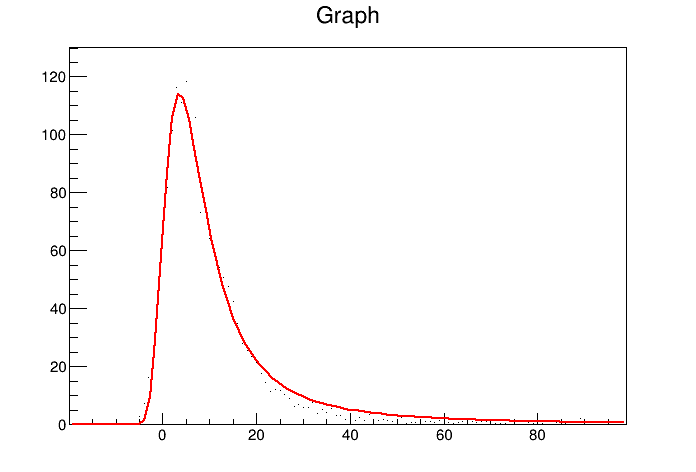

In [36]:
TFile()
c = TCanvas()

# bs = TGraph(xx.size, xx.astype(np.double),yy.astype(np.double))
g = TGraph(xx.size, xx.astype(np.double),yy.astype(np.double))

func = TF1("func",'landau')
# func = Fit('func','Chi2FCN')
# TF1("func","gaus(0)",0,10)

#Use a custom function (altough the build in pol2 would also work)
# func = TF1('func', '[0] + [1]*x + [2]*x**2', 0, 10)
fit = g.Fit('func', 'S')
# fit2 = bs.Fit('func', 'S')

# c.Draw()
# g.Draw('AP')

# func2 = TF1("func2",'gaus')
# fit2 = g.Fit('func2', 'S2')


g.Draw('AP')
c.Draw()
# b.Draw('same')

In [57]:
fit2.Get().Parameter(2)

3.00406361360174

In [49]:
import pylandau as pl

In [ ]:
pl.landau()

ValueError: x and y must have same first dimension, but have shapes (310,) and (100,)

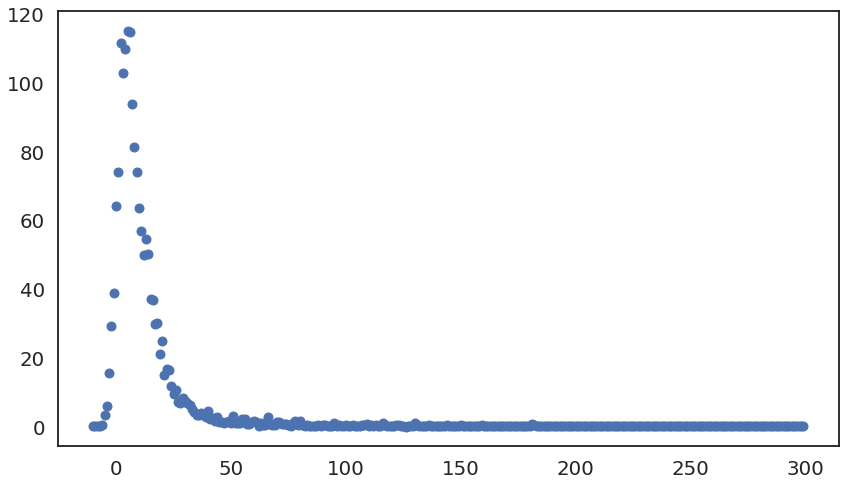


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      211.406
NDf                       =           97
Edm                       =   6.8885e-10
NCalls                    =          109
Constant                  =       254.56   +/-   3.66773     
MPV                       =      4.26992   +/-   0.0792692   
Sigma                     =      2.87578   +/-   0.0552272    	 (limited)


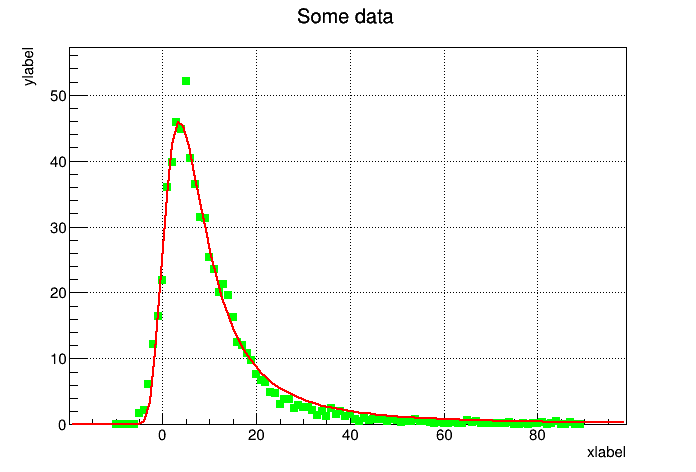

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()

#Activate seaborn styling
sns.set()
sns.set_context('talk', font_scale = 1.2)
sns.set_style('white')


#Function to calculate y
def pol2(x, p0, p1, p2):
    return p0+p1*x+p2*x**2

#Get fit parameters and generate a label
par = [fit.Get().Parameter(i) for i in range( 3 )]
# l = 'fit pol2 $p_0$: {:.3g} $p_1$: {:.3g} $p_2$: {:.2f}'.format(*par)

#Generate an array with finer steps than x
# xx = np.linspace(0, 10, 100)

#matplotlib figure and plot original and fitted data
plt.figure( figsize = (14,8) );
plt.plot(x, y, 'o', label = 'data');
plt.plot(x, pol2(xx, *par), label = l);

#Formatting and labels
plt.grid()
plt.legend()
sns.despine()
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('Matplotlib plot from ROOT fit');

In [65]:
stats.exponweib.fit(yy, floc=0, f0=1)

(1, 1.0, 0, 30.3764753741463)

In [66]:
plt.plot(x, stats.exponweib(x,))

TypeError: _parse_args() takes from 3 to 5 positional arguments but 6 were given

/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


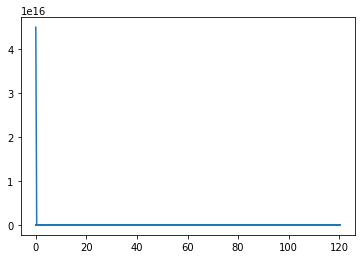

In [60]:
# >>> from scipy import stats
# >>> import matplotlib.pyplot as plt
plt.plot(yy, stats.exponweib.pdf(yy, *stats.exponweib.fit(yy, 1, 1, scale=0.2, loc=0)))
_ = plt.hist(yy, bins=np.linspace(0, 100, 1), normed=True, alpha=0.5);
plt.show()

In [24]:
(xf,yf),p,e,chi = fit.fit(fit.crystal_ball, x,y)
# plot(x,y, 'bo', label='Data')
# plot(xf,yf, 'r-', label='Fit')

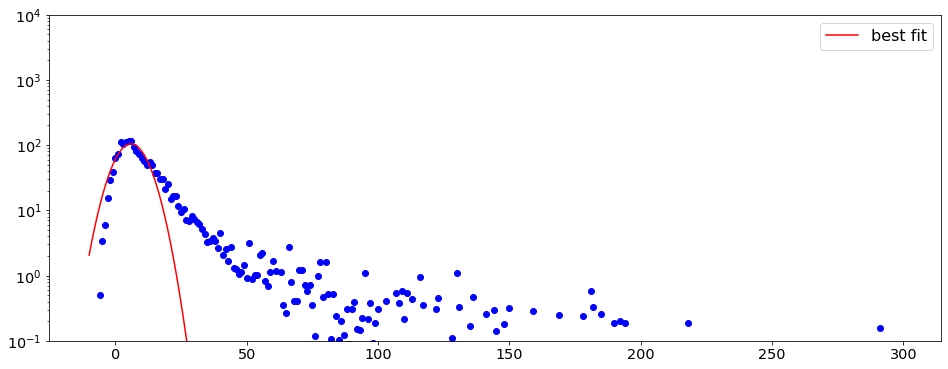

In [25]:
f,a = plt.subplots(1,1, figsize=(16, 6))
# plt.plot(x, result.init_fit, 'k--', label='initial fit')
a.plot(x, y, 'bo')
a.plot(xf, yf, 'r-', label='best fit')
# a.plot(x, log_der_func(x, par[0]), 'r-', label='best fit')
a.legend(loc='best')
a.set_ylim(10**-1,10**4)
a.tick_params(labelsize='x-large')
# a.set_xlim(-5,45)
a.legend(fontsize = 16)
a.set_yscale('log') 
plt.show()

In [45]:
func_fit = log_der_func_fit
func = log_der_func

In [46]:
par = scipy.optimize.curve_fit(func_fit,  x,  y_bkg
                                          ,maxfev=1000000)

/home/roberto/large_storage/documenti/1_Programming_Languages/Python/DEV_Python/Wh/utils.py:247: RuntimeWarning: overflow encountered in exp
  return N*(-ni)*((1+Q*np.exp(k*(x-xmax)))**(-ni-1))*Q*np.exp(k*(x-xmax))*k
/home/roberto/large_storage/documenti/1_Programming_Languages/Python/DEV_Python/Wh/utils.py:247: RuntimeWarning: invalid value encountered in multiply
  return N*(-ni)*((1+Q*np.exp(k*(x-xmax)))**(-ni-1))*Q*np.exp(k*(x-xmax))*k


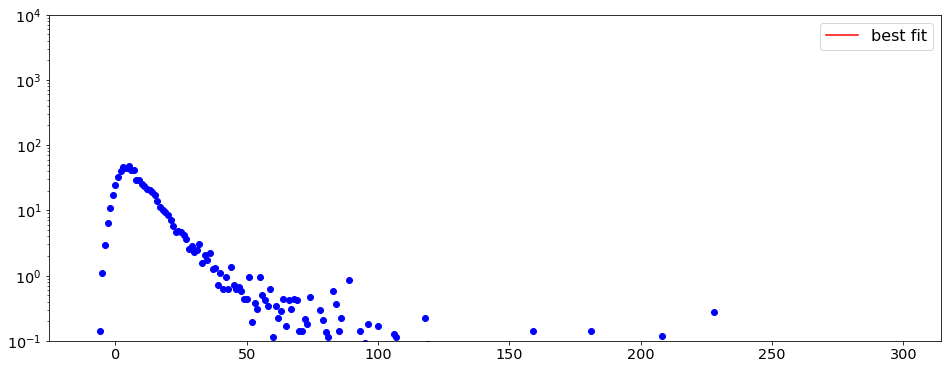

In [47]:
# plt.plot(x, y, 'bo')
f,a = plt.subplots(1,1, figsize=(16, 6))
# plt.plot(x, result.init_fit, 'k--', label='initial fit')
a.plot(x, y_bkg, 'bo')
a.plot(x, func(x, par[0]), 'r-', label='best fit')
# a.plot(x, log_der_func(x, par[0]), 'r-', label='best fit')
a.legend(loc='best')
a.set_ylim(10**-1,10**4)
a.tick_params(labelsize='x-large')
# a.set_xlim(-5,45)
a.legend(fontsize = 16)
a.set_yscale('log') 
plt.show()

In [183]:
import ROOT as rt

from ROOT import TCanvas, TFile, TPaveText
from ROOT import gROOT, gBenchmark
from ROOT import TF1

sqroot = gROOT.FindObject( 'sqroot' )
TFile()

import numpy as np
from ROOT import TCanvas, TGraph

# Some data
xx = x[:100]
yy = y_bkg[:100]

#Canvas to plot on and graph
c = TCanvas()
g = TGraph(xx.size, xx.astype(np.double),yy.astype(np.double))

#Draw canvas and graph
c.Draw()
g.Draw()

from ROOT import kGreen

#Formatting
g.SetLineColor( kGreen)
g.SetLineWidth( 2 )
g.SetMarkerColor( kGreen )
g.SetMarkerStyle( 21 )

#Labels and title
g.SetTitle('Some data')
g.GetXaxis().SetTitle('xlabel')
g.GetYaxis().SetTitle('ylabel')
c.SetGrid()
c.Draw()

#Draw (A)xis and (P)oints
g.Draw('AP')

from ROOT import Fit

func = TF1("func",'landau')
# func = Fit('func','Chi2FCN')
# TF1("func","gaus(0)",0,10)

#Use a custom function (altough the build in pol2 would also work)
# func = TF1('func', '[0] + [1]*x + [2]*x**2', 0, 10)
fit = g.Fit('func', 'S')

c.Draw()
g.Draw('AP')

import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()

#Activate seaborn styling
sns.set()
sns.set_context('talk', font_scale = 1.2)
sns.set_style('white')


#Function to calculate y
def pol2(x, p0, p1, p2):
    return p0+p1*x+p2*x**2

#Get fit parameters and generate a label
par = [fit.Get().Parameter(i) for i in range( 3 )]
# l = 'fit pol2 $p_0$: {:.3g} $p_1$: {:.3g} $p_2$: {:.2f}'.format(*par)

#Generate an array with finer steps than x
# xx = np.linspace(0, 10, 100)

#matplotlib figure and plot original and fitted data
plt.figure( figsize = (14,8) );
plt.plot(x, y, 'o', label = 'data');
plt.plot(x, pol2(xx, *par), label = l);

#Formatting and labels
plt.grid()
plt.legend()
sns.despine()
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('Matplotlib plot from ROOT fit');